In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_json('/kaggle/input/wildfiredata/wildfire_collection_feature_engineering_final.json')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659376 entries, 0 to 659375
Data columns (total 32 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _id       659376 non-null  object 
 1   cfb       659376 non-null  int64  
 2   locality  659376 non-null  object 
 3   rep_date  659376 non-null  object 
 4   lat       659376 non-null  float64
 5   lon       659376 non-null  float64
 6   temp      659376 non-null  float64
 7   wd        659376 non-null  int64  
 8   elev      659376 non-null  int64  
 9   rh        659376 non-null  int64  
 10  pcuring   659376 non-null  int64  
 11  day       659376 non-null  int64  
 12  ros       659376 non-null  float64
 13  year      659376 non-null  int64  
 14  month     659376 non-null  int64  
 15  hfi       659376 non-null  int64  
 16  tfc0      659376 non-null  float64
 17  sfl       659376 non-null  float64
 18  bui_lag2  659376 non-null  float64
 19  bui       659376 non-null  float64
 20  cfl 

In [5]:
df.drop(columns='_id', inplace=True)

In [6]:
from datetime import datetime

def return_date(date_string):
    #date_dict = eval(date_string)  # Convert the string to a dictionary
    date_value = date_string['$date']  # Get the value of the '$date' key
    return datetime.strptime(date_value, "%Y-%m-%dT%H:%M:%S.%fZ").date()  # Convert the string to a date object

df['rep_date'] = df['rep_date'].apply(return_date)
df.head()

,cfb,locality,rep_date,lat,lon,temp,wd,elev,rh,pcuring,...,dmc_lag5,dmc,sfc,dmc_lag7,bui_lag4,bfc,tfc,isi,bui_lag5,fwi_lag7
0,0,100 Mile House,2021-01-09,51.627403,-121.285294,-0.926,328,917,78,94,...,1.331,1.331,0.07,1.331,2.53,2.180375,0.07,0.046,2.53,0.015
1,0,100 Mile House,2021-01-10,51.547768,-121.402448,-0.926,328,917,78,94,...,1.331,1.331,0.07,1.331,2.53,2.180375,0.07,0.046,2.53,0.015
2,0,100 Mile House,2021-01-11,51.547768,-121.402448,-0.926,328,917,78,94,...,1.331,1.331,0.07,1.331,2.53,2.180375,0.07,0.046,2.53,0.015
3,0,100 Mile House,2021-01-12,51.547768,-121.402448,-0.926,328,917,78,94,...,1.331,1.331,0.07,1.331,2.53,2.180375,0.07,0.046,2.53,0.015
4,0,100 Mile House,2021-01-13,51.547768,-121.402448,-0.926,328,917,78,94,...,1.331,1.331,0.07,1.331,2.53,2.180375,0.07,0.046,2.53,0.015


In [7]:
df['cfb'] = df['cfb'].astype(float)

Split train and test data

In [8]:
import datetime

split_date = datetime.date(2023, 1, 1)
train_data = df[df['rep_date'] < split_date]
test_data = df[df['rep_date'] >= split_date]

In [9]:
train = train_data.reset_index()
train = (train.merge((train[['rep_date']].drop_duplicates(ignore_index=True).rename_axis('time_idx'))\
                     .reset_index(), on = ['rep_date'])).drop("rep_date", axis=1)

In [10]:
# Check for duplicates
duplicates = train[train.duplicated(['locality', 'time_idx'], keep=False)]
print("Duplicate rows:")
print(duplicates)

Duplicate rows:
         index   cfb        locality        lat         lon       temp   wd  \
200        200  63.0  100 Mile House  51.542999 -121.434998  26.851000  177   
201        201   0.0  100 Mile House  51.526001 -121.428001  26.940001  177   
202        202   0.0  100 Mile House  51.530998 -121.410004  26.900000  177   
203        203   0.0  100 Mile House  51.530998 -121.411003  25.910000  353   
204        204  35.0  100 Mile House  51.528999 -121.422997  25.934000  353   
...        ...   ...             ...        ...         ...        ...  ...   
605308  659367   0.0           Zhoda  49.299700  -96.576300  24.204000  152   
605309  659368   0.0           Zhoda  49.298000  -96.568900  24.204000  152   
605314  659373   0.0           Zhoda  49.282500  -96.587500  28.539000  103   
605315  659374   0.0           Zhoda  49.291300  -96.580100  28.561000  103   
605316  659375   0.0           Zhoda  49.279000  -96.578000  28.538000  103   

        elev  rh  pcuring  ...     

In [11]:
# Aggregate duplicate rows (using mean as an example)
train_unique = train.groupby(['locality', 'time_idx']).mean().reset_index()

# Verify that we now have unique combinations
assert train_unique.duplicated(['locality', 'time_idx']).sum() == 0, "Still have duplicates after aggregation"

In [12]:
# Create a complete time series for each locality
full_index = pd.MultiIndex.from_product(
    [train_unique['locality'].unique(), 
     range(train_unique['time_idx'].min(), train_unique['time_idx'].max() + 1)],
    names=['locality', 'time_idx']
)

# Reindex the dataframe and reset index to reintroduce locality and time_idx as columns
train_filled = train_unique.set_index(['locality', 'time_idx']).reindex(full_index).reset_index()

# Check the presence of 'locality' column
print(train_filled.columns)

# Forward fill the missing values within each group, but keep locality and time_idx intact
train_filled.update(train_filled.groupby('locality').ffill())

# If needed, backward fill remaining NaN values after forward fill
train_filled.update(train_filled.groupby('locality').bfill())

# Resulting DataFrame
print(train_filled)

Index(['locality', 'time_idx', 'index', 'cfb', 'lat', 'lon', 'temp', 'wd',
       'elev', 'rh', 'pcuring', 'day', 'ros', 'year', 'month', 'hfi', 'tfc0',
       'sfl', 'bui_lag2', 'bui', 'cfl', 'sfc0', 'dmc_lag5', 'dmc', 'sfc',
       'dmc_lag7', 'bui_lag4', 'bfc', 'tfc', 'isi', 'bui_lag5', 'fwi_lag7'],
      dtype='object')
              locality  time_idx     index  cfb        lat         lon  \
0       100 Mile House         0       0.0  0.0  51.627403 -121.285294   
1       100 Mile House         1       1.0  0.0  51.547768 -121.402448   
2       100 Mile House         2       2.0  0.0  51.547768 -121.402448   
3       100 Mile House         3       3.0  0.0  51.547768 -121.402448   
4       100 Mile House         4       4.0  0.0  51.547768 -121.402448   
...                ...       ...       ...  ...        ...         ...   
843088           Zhoda      1012  659374.0  0.0  49.284267  -96.581867   
843089           Zhoda      1013  659374.0  0.0  49.284267  -96.581867   
843090  

In [13]:
train_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843093 entries, 0 to 843092
Data columns (total 32 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   locality  843093 non-null  object 
 1   time_idx  843093 non-null  int64  
 2   index     843093 non-null  float64
 3   cfb       843093 non-null  float64
 4   lat       843093 non-null  float64
 5   lon       843093 non-null  float64
 6   temp      843093 non-null  float64
 7   wd        843093 non-null  float64
 8   elev      843093 non-null  float64
 9   rh        843093 non-null  float64
 10  pcuring   843093 non-null  float64
 11  day       843093 non-null  float64
 12  ros       843093 non-null  float64
 13  year      843093 non-null  float64
 14  month     843093 non-null  float64
 15  hfi       843093 non-null  float64
 16  tfc0      843093 non-null  float64
 17  sfl       843093 non-null  float64
 18  bui_lag2  843093 non-null  float64
 19  bui       843093 non-null  float64
 20  cfl 

### Transform Dataset to TimeSeriesDataset of Pytorch

In [14]:
train_filled['time_idx'].nunique()

1017

In [15]:
all_features = ['cfb', 'locality', 'temp', 'wd',
       'elev', 'rh', 'pcuring', 'day', 'ros', 'year', 'month', 'hfi', 'tfc0',
       'sfl', 'bui_lag2', 'bui', 'cfl', 'sfc0', 'dmc_lag5', 'dmc', 'sfc',    
       'dmc_lag7', 'bui_lag4', 'bfc', 'tfc', 'isi', 'bui_lag5', 'fwi_lag7']

In [16]:
train.index.nunique()

605317

In [17]:
lags = ['bui_lag2',  'dmc_lag5', 'dmc_lag7', 'bui_lag4', 'bui_lag5', 'fwi_lag7']
lag_values = {lag: df[lag].values for lag in lags}
for keys, values in lag_values.items():
    if min(values) > 0:
        print('negative lag')

In [18]:
!pip install pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.5/808.5 kB 19.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 6.7 MB/s eta 0:00:00


In [19]:
# Calculate the number of observations per locality
series_lengths = train_filled.groupby('locality')['time_idx'].max() - train_filled.groupby('locality')['time_idx'].min() + 1
print(series_lengths.describe())

count     829.0
mean     1017.0
std         0.0
min      1017.0
25%      1017.0
50%      1017.0
75%      1017.0
max      1017.0
Name: time_idx, dtype: float64


In [20]:
# Check for gaps in time series
def check_time_gaps(group):
    return group['time_idx'].diff().max()

gaps = train_filled.groupby('locality').apply(check_time_gaps)
print(gaps.describe())

count    829.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
dtype: float64


/tmp/ipykernel_34/2574669589.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gaps = train_filled.groupby('locality').apply(check_time_gaps)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `

Skewness:
Original: 3.0541086937050137
Log-transformed: 2.357635400983959
Quantile: [2.21589013]

Kurtosis:
Original: 8.280991213937872
Log-transformed: 3.7481713673034003
Quantile: [2.99636189]

Extreme Values:
count    843093.000000
mean          6.960893
std          20.640475
min           0.000000
1%            0.000000
5%            0.000000
50%           0.000000
95%          65.000000
99%          94.000000
max         100.000000
Name: cfb, dtype: float64


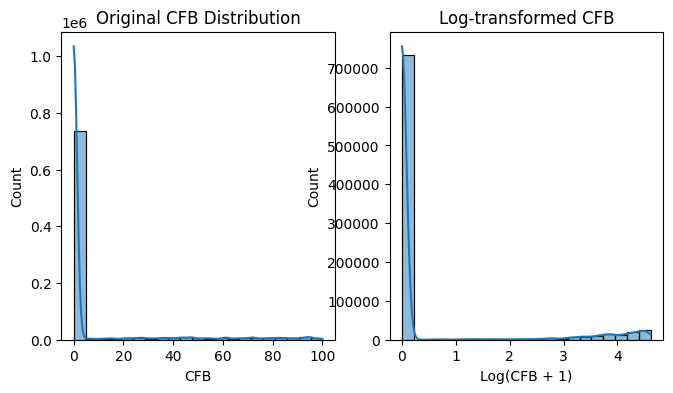

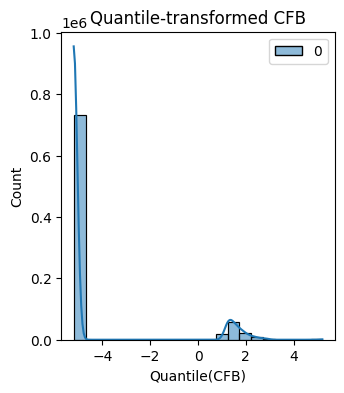

In [21]:
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import QuantileTransformer

# 1. Analyze the original distribution
plt.figure(figsize=(12, 4))
plt.subplot(131)
sns.histplot(train_filled['cfb'], kde=True)
plt.title('Original CFB Distribution')
plt.xlabel('CFB')

# 2. Log transformation (adding a small constant to handle zeros)
log_cfb = np.log1p(train_filled['cfb'])
plt.subplot(132)
sns.histplot(log_cfb, kde=True)
plt.title('Log-transformed CFB')
plt.xlabel('Log(CFB + 1)')

# 4. Quantile transformation
qt = QuantileTransformer(output_distribution='normal')
quantile_cfb = qt.fit_transform(train_filled[['cfb']])

plt.figure(figsize=(12, 4))
plt.subplot(131)
sns.histplot(quantile_cfb, kde=True)
plt.title('Quantile-transformed CFB')
plt.xlabel('Quantile(CFB)')

# 5. Calculate skewness and kurtosis for each transformation
print("Skewness:")
print(f"Original: {stats.skew(train_filled['cfb'])}")
print(f"Log-transformed: {stats.skew(log_cfb)}")
#print(f"Box-Cox: {stats.skew(boxcox_cfb)}")
print(f"Quantile: {stats.skew(quantile_cfb)}")

print("\nKurtosis:")
print(f"Original: {stats.kurtosis(train_filled['cfb'])}")
print(f"Log-transformed: {stats.kurtosis(log_cfb)}")
#print(f"Box-Cox: {stats.kurtosis(boxcox_cfb)}")
print(f"Quantile: {stats.kurtosis(quantile_cfb)}")

# 6. Extreme value analysis
print("\nExtreme Values:")
print(train_filled['cfb'].describe(percentiles=[0.01, 0.05, 0.95, 0.99]))

In [22]:
from sklearn.utils.class_weight import compute_class_weight
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE, QuantileLoss
import torch

# 1. Analyze the distribution of CFB values
zero_cfb_ratio = (train_filled['cfb'] == 0).mean()
print(f"Percentage of zero CFB values: {zero_cfb_ratio * 100:.2f}%")

# 2. Create a binary target for fire occurrence
train_filled['fire_occurrence'] = (train_filled['cfb'] > 0).astype(int)

# 3. Compute class weights for balanced learning
class_weights = compute_class_weight('balanced', classes=[0, 1], y=train_filled['fire_occurrence'])
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# 4. Custom loss function to handle imbalance
class WeightedQuantileLoss(QuantileLoss):
    def __init__(self, zero_weight=1.0, non_zero_weight=10.0, **kwargs):
        super().__init__(**kwargs)
        self.zero_weight = zero_weight
        self.non_zero_weight = non_zero_weight

    def loss(self, y_pred, y_actual):
        base_loss = super().loss(y_pred, y_actual)
        weights = torch.where(y_actual == 0, self.zero_weight, self.non_zero_weight)
        
        # Expand weights to match the shape of base_loss
        weights = weights.unsqueeze(-1).expand_as(base_loss)
        
        return (base_loss * weights).mean()

Percentage of zero CFB values: 86.87%


In [23]:
train_filled[train_filled['fire_occurrence'] >  0]

,locality,time_idx,index,cfb,lat,lon,temp,wd,elev,rh,...,dmc,sfc,dmc_lag7,bui_lag4,bfc,tfc,isi,bui_lag5,fwi_lag7,fire_occurrence
200,100 Mile House,200,201.0,21.0,51.533333,-121.424334,26.8970,177.0,1204.0,23.0,...,128.960335,3.933333,144.945999,160.941671,6.894135,4.024187,10.101000,165.811335,41.721001,1
201,100 Mile House,201,203.5,17.5,51.529999,-121.417000,25.9220,353.0,1200.0,29.0,...,134.051002,3.800000,133.785999,159.070503,7.071827,3.829775,10.768000,156.072006,36.333500,1
202,100 Mile House,202,205.5,37.0,51.535824,-121.435665,28.5645,158.0,1209.5,27.0,...,137.792999,3.825000,122.625999,164.581001,7.180570,4.013605,10.579500,163.482498,30.945999,1
203,100 Mile House,203,209.5,25.0,51.539834,-121.427333,29.5080,186.0,1205.5,22.0,...,143.880168,2.876667,131.961834,173.364166,5.030119,3.028440,11.505833,170.791168,38.688666,1
204,100 Mile House,204,209.5,25.0,51.539834,-121.427333,29.5080,186.0,1205.5,22.0,...,143.880168,2.876667,131.961834,173.364166,5.030119,3.028440,11.505833,170.791168,38.688666,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841054,Zama City,1012,658725.0,82.4,59.884842,-118.182494,12.3760,315.0,628.8,42.0,...,72.166800,3.540000,66.684001,106.148799,0.089905,3.796246,7.492200,105.723799,28.995599,1
841055,Zama City,1013,658725.0,82.4,59.884842,-118.182494,12.3760,315.0,628.8,42.0,...,72.166800,3.540000,66.684001,106.148799,0.089905,3.796246,7.492200,105.723799,28.995599,1
841056,Zama City,1014,658725.0,82.4,59.884842,-118.182494,12.3760,315.0,628.8,42.0,...,72.166800,3.540000,66.684001,106.148799,0.089905,3.796246,7.492200,105.723799,28.995599,1
841057,Zama City,1015,658725.0,82.4,59.884842,-118.182494,12.3760,315.0,628.8,42.0,...,72.166800,3.540000,66.684001,106.148799,0.089905,3.796246,7.492200,105.723799,28.995599,1


In [24]:
## Define the data schema
static_reals=['elev']
time_varying_known_reals=['month', 'day', 'year']
time_varying_unknown_reals=['cfb', 'temp', 'wd',
       'rh', 'pcuring', 'ros', 'hfi', 'tfc0',
       'sfl', 'bui', 'cfl', 'sfc0', 'dmc', 'sfc',    
       'bfc', 'tfc', 'isi', 'fire_occurrence']
max_prediction_length = 7  # predict 7 days ahead
max_encoder_length = 30  # use 30 days of history

# keep the validation set held-out
training_cutoff = train["time_idx"].max() - max_prediction_length

In [25]:
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss

target_normalizer = GroupNormalizer(
    groups=['locality'], 
    transformation="softplus"
)

train_dataset = TimeSeriesDataSet(
    train_filled[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    target='cfb',
    group_ids=['locality'],
    static_reals=static_reals,
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_reals=time_varying_unknown_reals,
    max_encoder_length=max_encoder_length,
    min_encoder_length=max_encoder_length//2,  
    max_prediction_length=max_prediction_length,
    min_prediction_length=max_prediction_length,
    target_normalizer=target_normalizer,
    add_relative_time_idx=True,
    add_target_scales=True
)

In [26]:
# create validation set (predict=True)
validation_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    train_filled,
    predict=True,
    stop_randomization=True,
)

In [27]:
# Define the model
# Use the weighted loss in the model definition
tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=1e-3,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=32,
   # output_size=7,  # number of quantiles
    loss=WeightedQuantileLoss(zero_weight=1.0, non_zero_weight=10.0),  # Adjust weights as needed
    log_interval=10,
    reduce_on_plateau_patience=10
)

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [29]:
# Function to print batch shapes
def print_batch_shapes(dataloader, name):
    for i, batch in enumerate(dataloader):
        x, y = batch
        print(f"{name} Batch {i+1}:")
        print(f"  Inputs shape: {x['encoder_cont'].shape}")
        print(f"  Decoder shape: {x['decoder_cont'].shape}")
        break


In [30]:
# Create dataloaders
batch_size = 64
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=4)

# Print shapes for train and validation dataloaders
print_batch_shapes(train_dataloader, "Train")
print_batch_shapes(val_dataloader, "Validation")

Train Batch 1:
  Inputs shape: torch.Size([64, 30, 26])
  Decoder shape: torch.Size([64, 7, 26])
Validation Batch 1:
  Inputs shape: torch.Size([640, 30, 26])
  Decoder shape: torch.Size([640, 7, 26])


In [31]:
# load the best model w.r.t. the validation loss
best_model_path = "/kaggle/input/trained-checkpoint-for-tft/checkpoints/best-checkpoint.ckpt"
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [33]:
if next(best_tft.parameters()).is_cuda:
    best_tft = best_tft.cpu()
predictions = best_tft.predict(val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2024-08-05 20:42:05.307572: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 20:42:05.307731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 20:42:05.455728: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this 

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictions = predictions.to(device)
actuals = torch.cat([y[0] for _, y in iter(val_dataloader)]).to(device)

# Initialize metrics on the same device
rmse = RMSE().to(device)
mae = MAE().to(device)

# Calculate and print RMSE and MAE
print(f"RMSE: {rmse(predictions, actuals)}")
print(f"MAE: {mae(predictions, actuals)}")

RMSE: 1.7555328607559204
MAE: 0.1974875032901764


In [36]:
# Get predictions and ensure they are on the same device
val_prediction_results = best_tft.predict(val_dataloader).to(device)

# Compute the mean absolute error
mae = (actuals - val_prediction_results).abs().mean()
print(f"Validation MAE: {mae.item()}")

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation MAE: 0.1974875032901764


In [37]:
val_prediction_results = best_tft.predict(val_dataloader, mode="raw", return_x=True)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


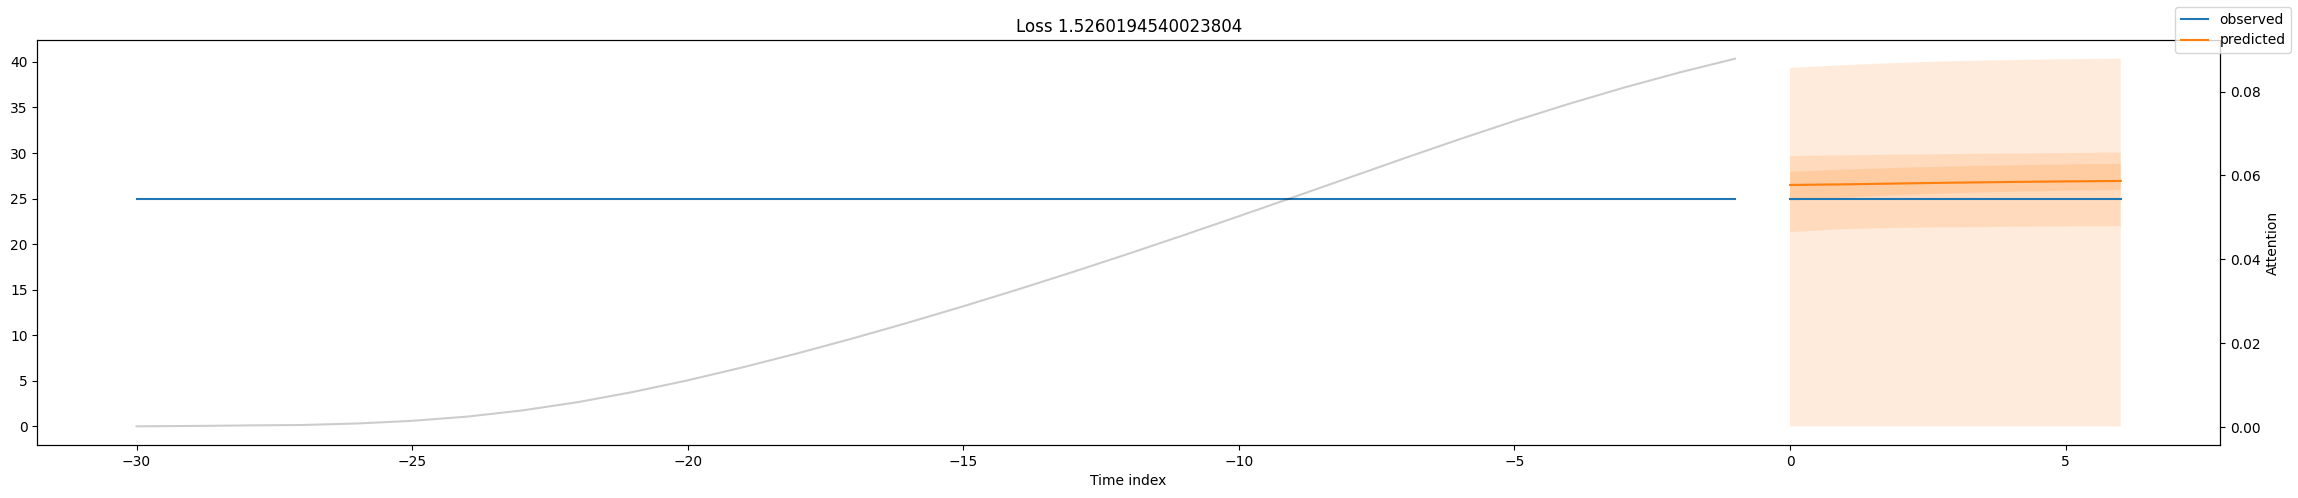

In [38]:
# Plot actuals vs prediction and attention
for idx in range(1):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(val_prediction_results.x, # network input
                            val_prediction_results.output, # network output
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax);

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x750 with 1 Axes>,
 'decoder_variables': <Figure size 700x300 with 1 Axes>}

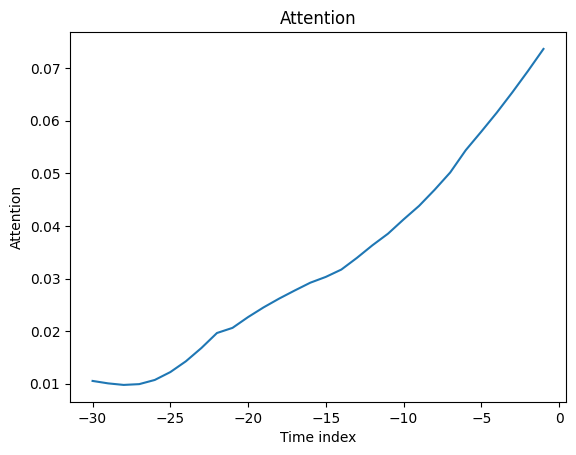

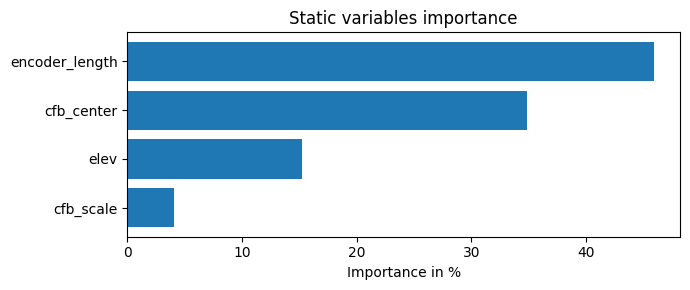

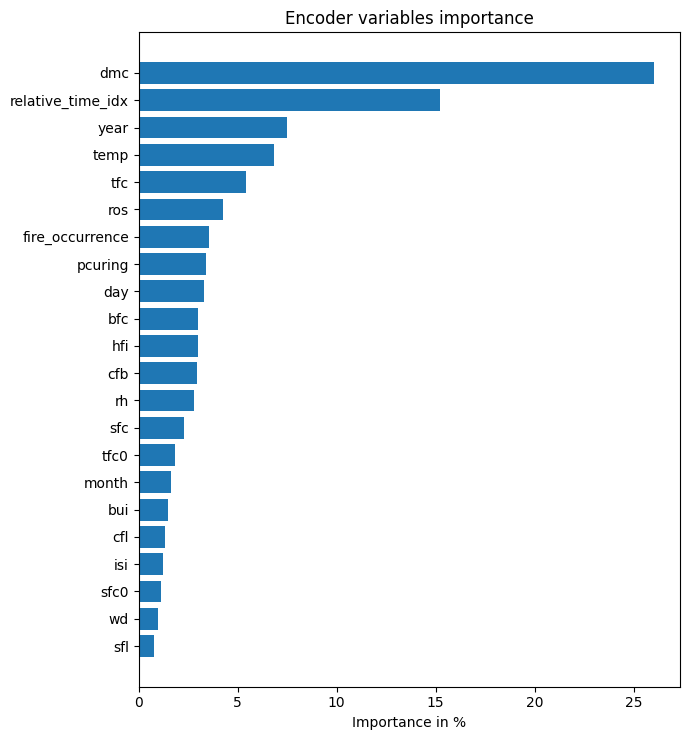

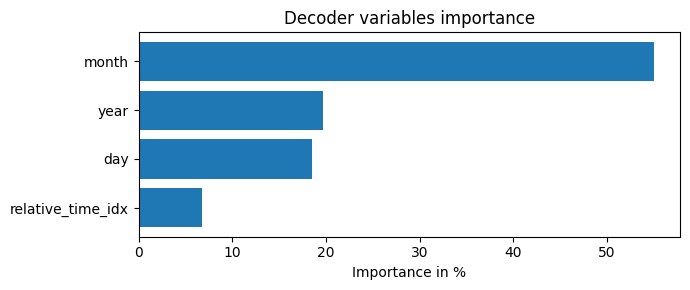

In [39]:
# plot variable importance
interpretation = best_tft.interpret_output(val_prediction_results.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

# **Inferencing and Testing for 2023**

In [40]:
test = test_data.reset_index()
test = (test.merge((test[['rep_date']].drop_duplicates(ignore_index=True).rename_axis('time_idx'))\
                     .reset_index(), on = ['rep_date'])).drop("rep_date", axis=1)

In [42]:
# Aggregate duplicate rows (using mean as an example)
test_unique = test.groupby(['locality', 'time_idx']).mean().reset_index()

# Verify that we now have unique combinations
assert test_unique.duplicated(['locality', 'time_idx']).sum() == 0, "Still have duplicates after aggregation"

In [43]:
# Create a complete time series for each locality
full_index = pd.MultiIndex.from_product(
    [test_unique['locality'].unique(), 
     range(test_unique['time_idx'].min(), test_unique['time_idx'].max() + 1)],
    names=['locality', 'time_idx']
)

# Reindex the dataframe and reset index to reintroduce locality and time_idx as columns
test_filled = test_unique.set_index(['locality', 'time_idx']).reindex(full_index).reset_index()

# Check the presence of 'locality' column
print(test_filled.columns)

# Forward fill the missing values within each group, but keep locality and time_idx intact
test_filled.update(test_filled.groupby('locality').ffill())

# If needed, backward fill remaining NaN values after forward fill
test_filled.update(test_filled.groupby('locality').bfill())

# Resulting DataFrame
print(test_filled)

Index(['locality', 'time_idx', 'index', 'cfb', 'lat', 'lon', 'temp', 'wd',
       'elev', 'rh', 'pcuring', 'day', 'ros', 'year', 'month', 'hfi', 'tfc0',
       'sfl', 'bui_lag2', 'bui', 'cfl', 'sfc0', 'dmc_lag5', 'dmc', 'sfc',
       'dmc_lag7', 'bui_lag4', 'bfc', 'tfc', 'isi', 'bui_lag5', 'fwi_lag7'],
      dtype='object')
                locality  time_idx     index      cfb        lat         lon  \
0          70 Mile House         0    2464.0   0.0000  51.441233 -121.489295   
1          70 Mile House         1    2465.0   0.0000  51.441233 -121.489295   
2          70 Mile House         2    2466.0   0.0000  51.441233 -121.489295   
3          70 Mile House         3    2467.0   0.0000  51.441233 -121.489295   
4          70 Mile House         4    2468.0   0.0000  51.441233 -121.489295   
...                  ...       ...       ...      ...        ...         ...   
65697  Yellowhead County       242  654626.5  68.8125  53.379354 -116.148469   
65698  Yellowhead County       243

In [44]:
# Check for gaps in time series
def check_time_gaps(group):
    return group['time_idx'].diff().max()

gaps = test_filled.groupby('locality').apply(check_time_gaps)
print(gaps.describe())

count    266.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
dtype: float64


/tmp/ipykernel_34/3462764073.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gaps = test_filled.groupby('locality').apply(check_time_gaps)


In [45]:
# 1. Analyze the distribution of CFB values
zero_cfb_ratio = (test_filled['cfb'] == 0).mean()
print(f"Percentage of zero CFB values: {zero_cfb_ratio * 100:.2f}%")

# 2. Create a binary target for fire occurrence
test_filled['fire_occurrence'] = (test_filled['cfb'] > 0).astype(int)

Percentage of zero CFB values: 86.29%


In [46]:
test_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65702 entries, 0 to 65701
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   locality         65702 non-null  object 
 1   time_idx         65702 non-null  int64  
 2   index            65702 non-null  float64
 3   cfb              65702 non-null  float64
 4   lat              65702 non-null  float64
 5   lon              65702 non-null  float64
 6   temp             65702 non-null  float64
 7   wd               65702 non-null  float64
 8   elev             65702 non-null  float64
 9   rh               65702 non-null  float64
 10  pcuring          65702 non-null  float64
 11  day              65702 non-null  float64
 12  ros              65702 non-null  float64
 13  year             65702 non-null  float64
 14  month            65702 non-null  float64
 15  hfi              65702 non-null  float64
 16  tfc0             65702 non-null  float64
 17  sfl         

In [47]:
from pytorch_forecasting.data.encoders import NaNLabelEncoder
for encoder in train_dataset.categorical_encoders.values():
    if isinstance(encoder, NaNLabelEncoder):
        encoder.add_nan = True

In [48]:
# Create test dataset
test_dataset = TimeSeriesDataSet.from_dataset(train_dataset,
                                        test_filled, 
                                        predict=True, 
                                        stop_randomization=True)

# Create test dataloader
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

# Get prediction results
test_prediction_results = best_tft.predict(
    test_dataloader,
    mode="raw",
    return_index=True, # return the prediction index in the same order as the output
    return_x=True, # return network inputs in the same order as prediction output
    )

/opt/conda/lib/python3.10/site-packages/pytorch_forecasting/data/encoders.py:318: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


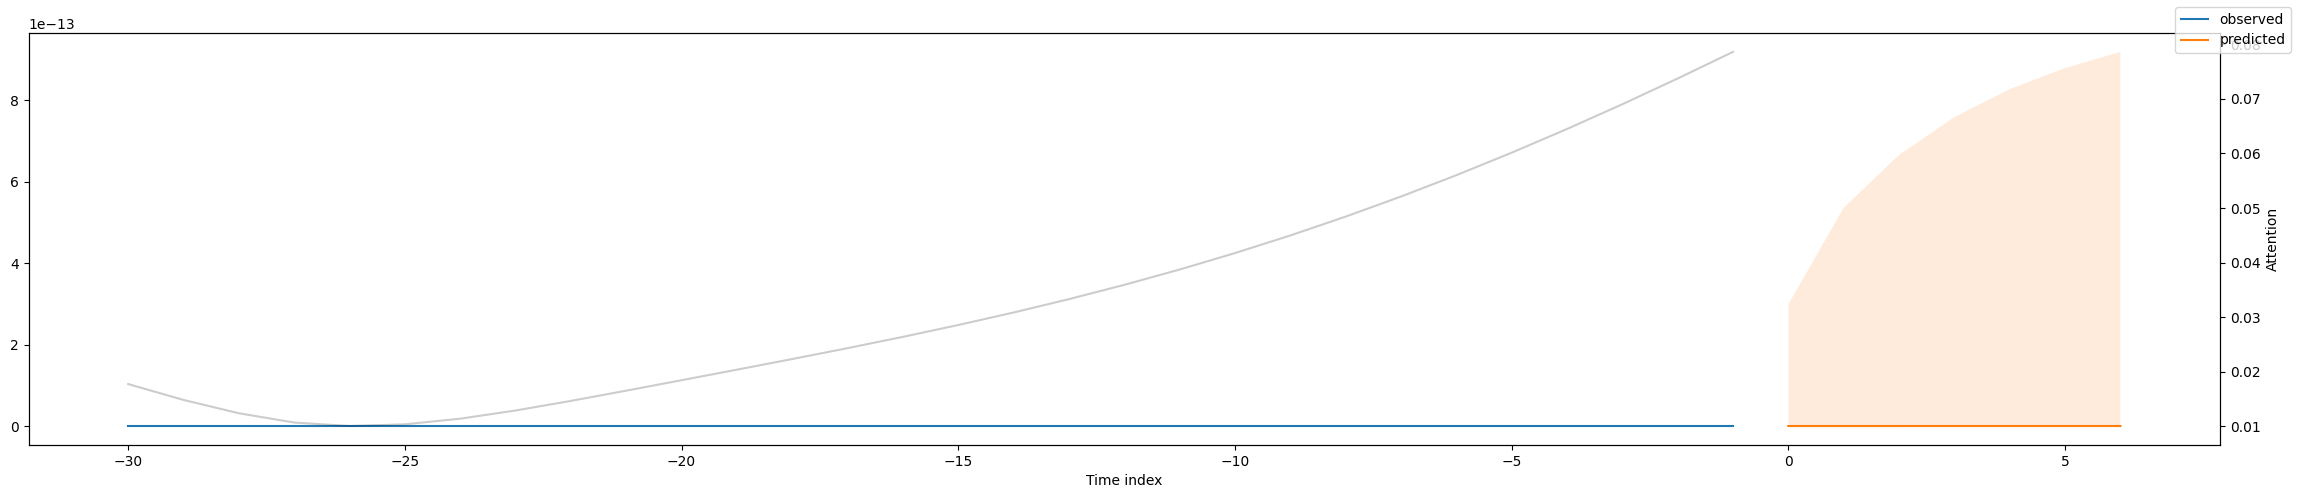

In [49]:
for idx in range(1):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(
        test_prediction_results.x, 
        test_prediction_results.output, 
        idx=idx, 
        show_future_observed=False,
        # add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
        ax=ax,
        )

In [50]:
test_prediction_results.output.prediction.cpu().numpy().shape

(266, 7, 7)

In [51]:
test_prediction_results.index['locality']

0          70 Mile House
1               Aguanish
2              Air Ronge
3           Alexis Creek
4               Alticane
             ...        
261              Wonowon
262              Worsley
263              Wroxton
264    Yellowhead County
265              Wembley
Name: locality, Length: 266, dtype: object

In [ ]:
test_prediction_results.index

In [53]:
print('Shape of test_prediction_results.output.prediction:', test_prediction_results.output.prediction.shape)

Shape of test_prediction_results.output.prediction: torch.Size([266, 7, 7])


In [55]:
print('Structure of test_prediction_results.index:\n', test_prediction_results.index)


Structure of test_prediction_results.index:
      time_idx           locality
0         240      70 Mile House
1         240           Aguanish
2         240          Air Ronge
3         240       Alexis Creek
4         240           Alticane
..        ...                ...
261       240            Wonowon
262       240            Worsley
263       240            Wroxton
264       240  Yellowhead County
265       240            Wembley

[266 rows x 2 columns]


In [59]:
test_prediction_results.output.prediction.median(dim=1)

torch.return_types.median(
values=tensor([[4.4151e-20, 9.2126e-19, 1.0886e-17,  ..., 1.1203e-16, 6.1715e-16,
         7.5830e-13],
        [1.0628e-33, 2.2190e-29, 5.2618e-19,  ..., 3.2987e-11, 2.7032e-04,
         6.7464e+01],
        [1.2493e-36, 4.5504e-31, 3.5141e-23,  ..., 2.2217e-16, 1.7467e-10,
         3.2643e+01],
        ...,
        [2.2169e-16, 2.2187e-16, 2.2195e-16,  ..., 2.2204e-16, 2.2210e-16,
         2.2238e-16],
        [2.2205e-16, 2.2245e-16, 2.2248e-16,  ..., 2.2267e-16, 2.2269e-16,
         2.2278e-16],
        [2.2189e-16, 2.2232e-16, 2.2234e-16,  ..., 2.2238e-16, 2.2240e-16,
         2.2247e-16]], device='cuda:0'),
indices=tensor([[5, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [6, 3, 3,  ..., 3, 3, 3],
        ...,
        [4, 3, 3,  ..., 3, 3, 3],
        [3, 4, 3,  ..., 3, 6, 3],
        [3, 4, 3,  ..., 3, 3, 3]], device='cuda:0'))

In [78]:
def map_predictions_to_dataframe(test_data, test_prediction_results):
    # Create a copy of the test data
    predictions_df = test_filled.copy()
    
    median_predictions, _ = test_prediction_results.output.prediction.median(dim=1)
    median_predictions = median_predictions.cpu().numpy()[:,1]
    
    # Print shape of median_predictions for debugging
    print('Shape of median_predictions:', median_predictions.shape)
    
    # Extract locality values from the index DataFrame
    locality_values = test_prediction_results.index['locality'].values
    
    # Print lengths for debugging
    print('Length of predictions_df:', len(predictions_df))
    print('Length of median_predictions:', len(median_predictions))
    print('Length of locality_values:', len(locality_values))
    
    # Ensure the lengths match
    if len(median_predictions) != len(locality_values):
        raise ValueError("Mismatch in lengths between median_predictions and test_prediction_results.index")
    
    # Create a mapping DataFrame from the test prediction results
    mapping_df = pd.DataFrame({
        'locality': locality_values,
        'cfb': median_predictions
    })

    # Merge the mapping DataFrame with the predictions DataFrame
    predictions_df = predictions_df.merge(mapping_df, on='locality', how='left', suffixes=('', '_pred'))
    
    return predictions_df

# Usage
predictions_df = map_predictions_to_dataframe(test_data, test_prediction_results)
print(predictions_df)

Shape of median_predictions: (266,)
Length of predictions_df: 65702
Length of median_predictions: 266
Length of locality_values: 266
                locality  time_idx     index      cfb        lat         lon  \
0          70 Mile House         0    2464.0   0.0000  51.441233 -121.489295   
1          70 Mile House         1    2465.0   0.0000  51.441233 -121.489295   
2          70 Mile House         2    2466.0   0.0000  51.441233 -121.489295   
3          70 Mile House         3    2467.0   0.0000  51.441233 -121.489295   
4          70 Mile House         4    2468.0   0.0000  51.441233 -121.489295   
...                  ...       ...       ...      ...        ...         ...   
65697  Yellowhead County       242  654626.5  68.8125  53.379354 -116.148469   
65698  Yellowhead County       243  654626.5  68.8125  53.379354 -116.148469   
65699  Yellowhead County       244  654626.5  68.8125  53.379354 -116.148469   
65700  Yellowhead County       245  654626.5  68.8125  53.379354 -1

In [80]:
predictions_df[['cfb', 'cfb_pred']]

,cfb,cfb_pred
0,0.0000,9.212629e-19
1,0.0000,9.212629e-19
2,0.0000,9.212629e-19
3,0.0000,9.212629e-19
4,0.0000,9.212629e-19
...,...,...
65697,68.8125,2.224477e-16
65698,68.8125,2.224477e-16
65699,68.8125,2.224477e-16
65700,68.8125,2.224477e-16


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


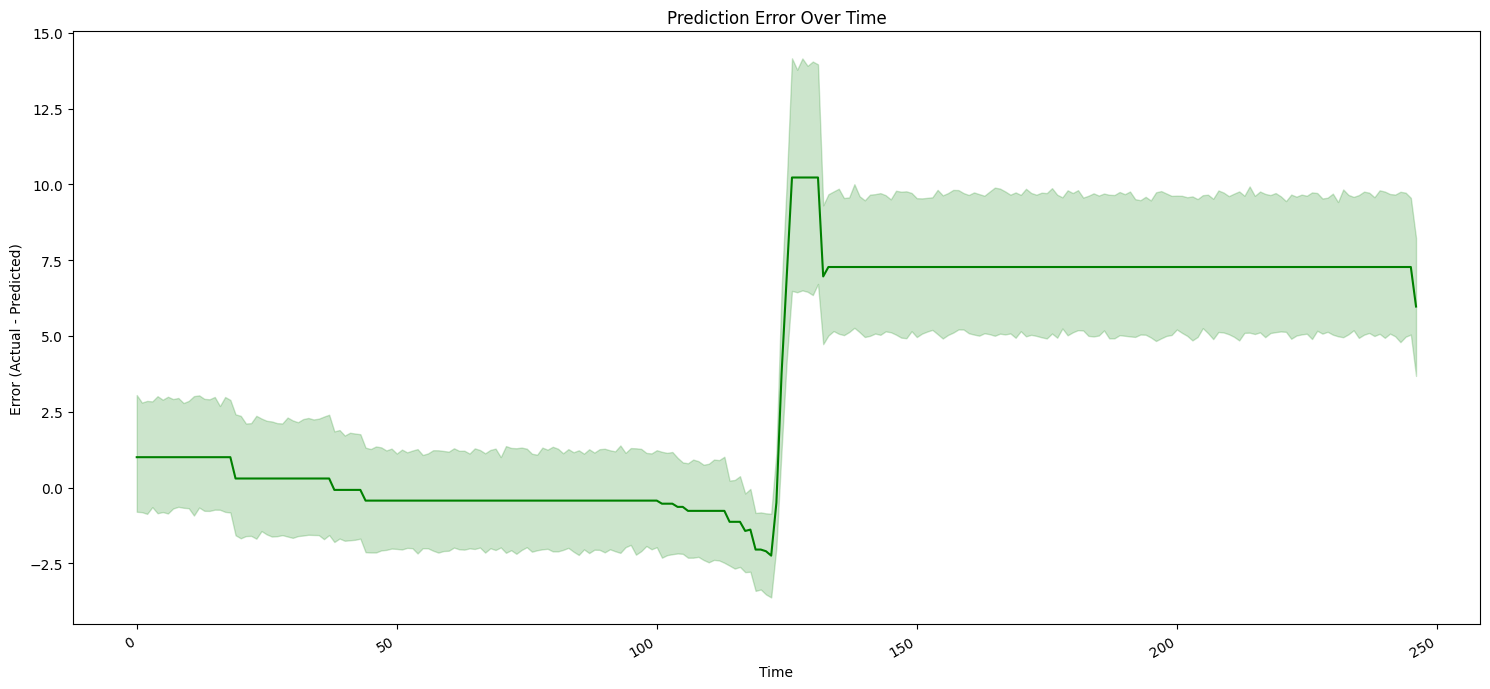

In [82]:
plt.figure(figsize=(15, 7))
predictions_df['Difference'] = predictions_df['cfb'] - predictions_df['cfb_pred']
sns.lineplot(data=predictions_df, x='time_idx', y='Difference', color='green')

plt.title('Prediction Error Over Time')
plt.xlabel('Time')
plt.ylabel('Error (Actual - Predicted)')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()